In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Import data
path = '/Users/thainam/Documents/GitHub/grey-model/data/data_render/nCoV_data_render.csv'
data = pd.read_csv(path)
data["Date"] = pd.to_datetime(data["Date"])
index_data = data.set_index(["Date"], drop=True)

# Check data
index_data.head()

,Total cases
Date,
2020-01-28,6061
2020-01-29,7816
2020-01-30,9821
2020-01-31,11948
2020-02-01,14551


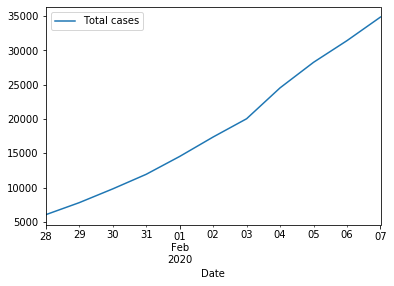

In [3]:
df = index_data[["Total cases"]]
df.plot()

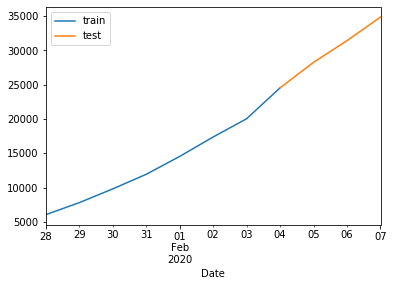

In [4]:
# Split data
split_date = pd.Timestamp('2020-02-04')

train = df.loc[:split_date]
test = df.loc[split_date:]

# Plot splitted data
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [5]:
# Scaling
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
train_scale = scale.fit_transform(train)
test_scale = scale.transform(test)

In [6]:
# Long Short-term Memory

# Split data into x (train,test) and y (train,test)
X_train = train_scale[:-1]
y_train = train_scale[1:]

X_test = test_scale[:-1]
y_test = test_scale[1:]

In [7]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [40]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM

K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(10, input_shape = (1, X_train.shape[1]), activation = 'relu', kernel_initializer= 'lecun_uniform', return_sequences = False))
model_lstm.add(Dense(1))
model_lstm.compile(loss = 'mean_squared_error', optimizer = 'adam')
early_stop = EarlyStopping(monitor = 'loss', patience = 15, verbose = 1)
history = model_lstm.fit(X_tr_t, y_train, epochs = 100, validation_data=(X_tst_t, y_test), batch_size = 1, verbose = 1, shuffle = False, callbacks = [early_stop])

Train on 7 samples, validate on 3 samples
Epoch 1/100
7/7 [==============================] - 0s 51ms/step - loss: 0.3225 - val_loss: 1.4540
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3085 - val_loss: 1.4018
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2946 - val_loss: 1.3497
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2812 - val_loss: 1.2986
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2683 - val_loss: 1.2489
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2559 - val_loss: 1.2007
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2441 - val_loss: 1.1538
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2327 - val_loss: 1.1083
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2218 - val_loss: 1.0639
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2113 - val

7/7 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0062
Epoch 85/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0057
Epoch 86/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0053
Epoch 87/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0049
Epoch 88/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0045
Epoch 89/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.0041
Epoch 90/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0038
Epoch 91/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0127 - val_loss: 0.0035
Epoch 92/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0032
Epoch 93/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0030
Epoch 94/100
7/7 [===============

In [41]:
# Prediction
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

In [42]:
model_lstm.save('LSTM_nCoV.h5')

In [43]:
model_lstm = load_model('LSTM_nCoV.h5')
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

In [44]:
# R2 score
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

# MAPE
def MAPE(y, y_pred):
    y, y_pred = np.array(y), np.array(y_pred)
    return (np.mean(np.abs((y - y_pred) / y)) * 100) 

In [45]:
# Save data
col1 = pd.DataFrame(y_test, columns=['True'])
col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM Prediction'])
col3 = pd.DataFrame(history.history['loss'], columns=['Loss_LSTM'])

results = pd.concat([col1, col2, col3], axis=1)
results.to_csv('LSTM_Result.csv')

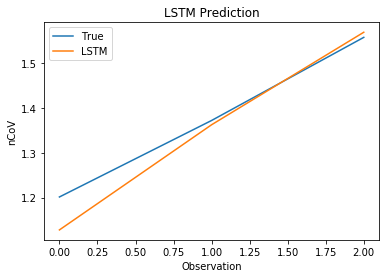

3/3 [==============================] - 0s 17ms/step
LSTM: 0.001882
The R2 score on the Train set is:	0.871190847
The Adjusted R2 score on the Train set is:	0.845429016

The R2 score on the Test set is:	0.911363801
The Adjusted R2 score on the Test set is:	0.822727602
MAPE score is: 2.5211140044090374


In [46]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# Graphing
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM Prediction")
plt.xlabel('Observation')
plt.ylabel('nCoV')
plt.legend()
plt.show()

# Scoring
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)
print('LSTM: %f'%score_lstm)

# R2 Scores
print("The R2 score on the Train set is:\t{:0.9f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.9f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.9f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.9f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

# MAPE Score
print("MAPE score is: " + str(MAPE(y_test, y_pred_test_LSTM)))

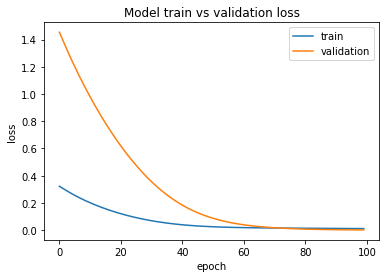

In [47]:
# Graphing loss vs validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()